In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from collections import defaultdict

np.set_printoptions(precision=6, suppress=True)
%matplotlib inline

display(Markdown("## STEP 1 — Imports and settings"))
print("numpy, networkx, matplotlib imported. Matplotlib inline set.")


## STEP 1 — Imports and settings

numpy, networkx, matplotlib imported. Matplotlib inline set.


## STEP 2 — Load Karate Club graph, show basic info, adjacency matrix and plot

Loaded graph: n=34, m=78

Adjacency matrix A (rounded):
[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

Displaying full graph:


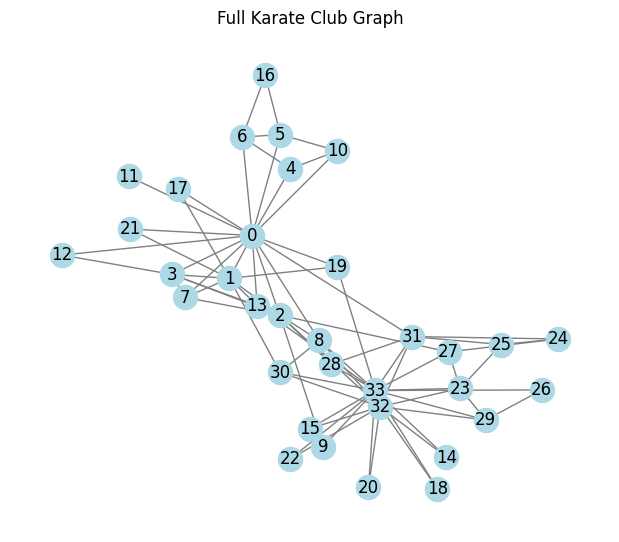

In [14]:
display(Markdown("## STEP 2 — Load Karate Club graph, show basic info, adjacency matrix and plot"))

G = nx.karate_club_graph()
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
A = nx.to_numpy_array(G, nodelist=nodes)
deg = np.array([G.degree(u) for u in nodes], dtype=float)
two_m = 2 * m
pos = nx.spring_layout(G, seed=42)

print(f"Loaded graph: n={n}, m={m}")
print("\nAdjacency matrix A (rounded):")
print(np.round(A, 4))

print("\nDisplaying full graph:")
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray')
plt.title("Full Karate Club Graph")
plt.show()


In [15]:
display(Markdown("## STEP 3 — Define modularity_matrix_restricted and demo on full node set"))

def modularity_matrix_restricted(node_list, verbose=True):
    display(Markdown(f"**Action:** computing modularity matrix for node list: {node_list}"))
    idx = [nodes.index(u) for u in node_list]
    A_sub = A[np.ix_(idx, idx)]
    k_sub = deg[idx]
    B_sub = A_sub - np.outer(k_sub, k_sub) / two_m
    if verbose:
        print("\nA_sub (adjacency of subgraph):")
        print(np.round(A_sub, 6))
        print("\nB_sub (modularity matrix of subgraph):")
        print(np.round(B_sub, 6))
    return B_sub, idx

# Demo run on the full set (so you see outputs right away)
B_full, idx_full = modularity_matrix_restricted(nodes, verbose=True)


## STEP 3 — Define modularity_matrix_restricted and demo on full node set

**Action:** computing modularity matrix for node list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


A_sub (adjacency of subgraph):
[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

B_sub (modularity matrix of subgraph):
[[-1.641026  3.076923  3.974359 ...  1.384615 -1.230769 -1.74359 ]
 [ 3.076923 -0.519231  5.423077 ... -0.346154 -0.692308 -0.980769]
 [ 3.974359  5.423077 -0.641026 ... -0.384615  1.230769 -1.089744]
 ...
 [ 1.384615 -0.346154 -0.384615 ... -0.230769  3.538462  3.346154]
 [-1.230769 -0.692308  1.230769 ...  3.538462 -0.923077  3.692308]
 [-1.74359  -0.980769 -1.089744 ...  3.346154  3.692308 -1.852564]]


In [16]:
display(Markdown("## STEP 4 — Define leading_eigenpair and run on B_sub"))

def leading_eigenpair(B, k_print=6):
    display(Markdown("**Action:** computing eigen-decomposition of provided B_sub"))
    w, v = np.linalg.eigh(B)                  # symmetric matrix eigendecomp
    idx_sorted = np.argsort(w)[::-1]          # descending
    w_sorted = w[idx_sorted]
    v_sorted = v[:, idx_sorted]
    print("Top eigenvalues (descending):", np.round(w_sorted[:k_print], 6))
    print("\nTop eigenvector (entries, rounded):")
    print(np.round(v_sorted[:, 0], 6))
    return w_sorted[0], v_sorted[:, 0]

# Demo run
lam_full, u_full = leading_eigenpair(B_full)
print(f"\nLeading eigenvalue = {lam_full:.6f}")


## STEP 4 — Define leading_eigenpair and run on B_sub

**Action:** computing eigen-decomposition of provided B_sub

Top eigenvalues (descending): [17.107387 15.051246  9.278077  7.787504  4.637811  3.667466]

Top eigenvector (entries, rounded):
[-0.323652 -0.325258 -0.26399  -0.242372 -0.08232  -0.107637 -0.10534
 -0.218992  0.04047   0.024682 -0.071805 -0.056975 -0.061859 -0.180885
  0.099982  0.140532 -0.037786 -0.057288  0.060069 -0.056244  0.079706
 -0.0763    0.100301  0.295845  0.067146  0.178108  0.084822  0.130312
  0.033159  0.191213  0.088891  0.20638   0.341398  0.346855]

Leading eigenvalue = 17.107387


In [17]:
display(Markdown("## STEP 5 — Define draw utilities (draw_full_partition, draw_induced_subgraph)"))

def draw_full_partition(partition, title=None):
    # partition: list of communities (each list of node ids)
    assign = {}
    for cid, comp in enumerate(partition):
        for v in comp:
            assign[v] = cid
    colors = [assign.get(v, -1) for v in nodes]
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, node_color=colors, cmap='tab20', with_labels=True, node_size=300, edge_color='gray')
    if title:
        plt.title(title)
    plt.show()
    print("Displayed full partition (colored by community id).")

def draw_induced_subgraph(node_list, title=None):
    display(Markdown(f"**Action:** display induced subgraph for nodes: {node_list}"))
    subG = G.subgraph(node_list)
    plt.figure(figsize=(5,4))
    nx.draw(G, pos, node_color='lightgray', with_labels=False, node_size=120, edge_color='lightgray')
    nx.draw_networkx_nodes(subG, pos, node_size=400, node_color='orange')
    nx.draw_networkx_labels(subG, pos)
    nx.draw_networkx_edges(subG, pos, width=2.0)
    if title:
        plt.title(title)
    plt.show()
    print(f"Displayed induced subgraph of size {len(node_list)}.")
    
print("Draw utilities defined. Try: draw_induced_subgraph([0,1,2])")


## STEP 5 — Define draw utilities (draw_full_partition, draw_induced_subgraph)

Draw utilities defined. Try: draw_induced_subgraph([0,1,2])


## STEP 6 — Define spectral_bisect and demo

**Action:** attempting spectral bisection on node list of size 34

**Action:** computing modularity matrix for node list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


A_sub (adjacency of subgraph):
[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

B_sub (modularity matrix of subgraph):
[[-1.641026  3.076923  3.974359 ...  1.384615 -1.230769 -1.74359 ]
 [ 3.076923 -0.519231  5.423077 ... -0.346154 -0.692308 -0.980769]
 [ 3.974359  5.423077 -0.641026 ... -0.384615  1.230769 -1.089744]
 ...
 [ 1.384615 -0.346154 -0.384615 ... -0.230769  3.538462  3.346154]
 [-1.230769 -0.692308  1.230769 ...  3.538462 -0.923077  3.692308]
 [-1.74359  -0.980769 -1.089744 ...  3.346154  3.692308 -1.852564]]


**Action:** computing eigen-decomposition of provided B_sub

Top eigenvalues (descending): [17.107387 15.051246  9.278077  7.787504  4.637811  3.667466]

Top eigenvector (entries, rounded):
[-0.323652 -0.325258 -0.26399  -0.242372 -0.08232  -0.107637 -0.10534
 -0.218992  0.04047   0.024682 -0.071805 -0.056975 -0.061859 -0.180885
  0.099982  0.140532 -0.037786 -0.057288  0.060069 -0.056244  0.079706
 -0.0763    0.100301  0.295845  0.067146  0.178108  0.084822  0.130312
  0.033159  0.191213  0.088891  0.20638   0.341398  0.346855]
Result: split into sizes 18 (pos) and 16 (neg).


**Action:** display induced subgraph for nodes: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

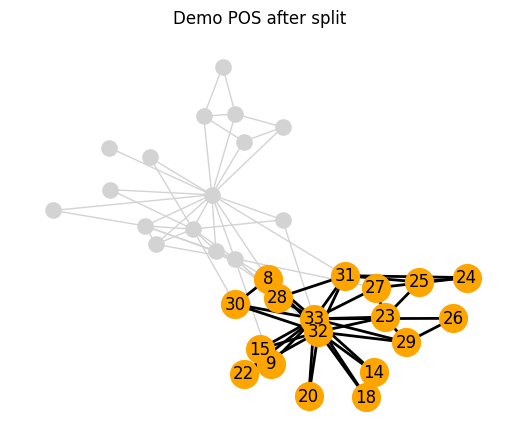

Displayed induced subgraph of size 18.


**Action:** display induced subgraph for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]

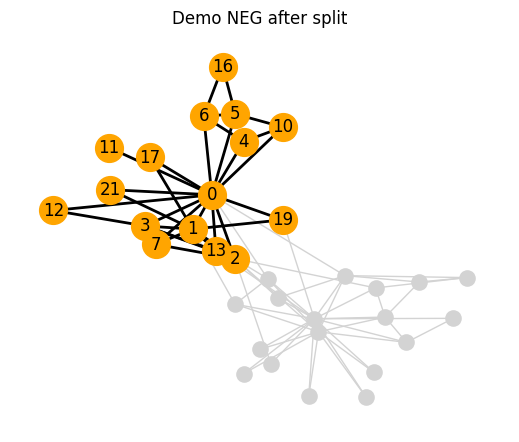

Displayed induced subgraph of size 16.


In [18]:
display(Markdown("## STEP 6 — Define spectral_bisect and demo"))

def spectral_bisect(node_list, threshold=1e-10, verbose=True):
    display(Markdown(f"**Action:** attempting spectral bisection on node list of size {len(node_list)}"))
    B_sub, idx = modularity_matrix_restricted(node_list, verbose=verbose)
    lam, u = leading_eigenpair(B_sub)
    if lam <= threshold:
        print("Result: NO split (leading eigenvalue <= threshold).")
        return None, lam, u
    pos_nodes = [node_list[i] for i in range(len(node_list)) if u[i] > 0]
    neg_nodes = [node_list[i] for i in range(len(node_list)) if u[i] <= 0]
    print(f"Result: split into sizes {len(pos_nodes)} (pos) and {len(neg_nodes)} (neg).")
    return (pos_nodes, neg_nodes), lam, u

# Demo (on full node set) and display the resulting induced subgraphs if split occurs
result_demo, lam_demo, u_demo = spectral_bisect(nodes)
if result_demo is not None:
    pos_demo, neg_demo = result_demo
    draw_induced_subgraph(pos_demo, title="Demo POS after split")
    draw_induced_subgraph(neg_demo, title="Demo NEG after split")


## Running recursive spectral split on: **Karate Club**

Loaded Karate Club: n=34, m=78

Adjacency matrix A:
[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]


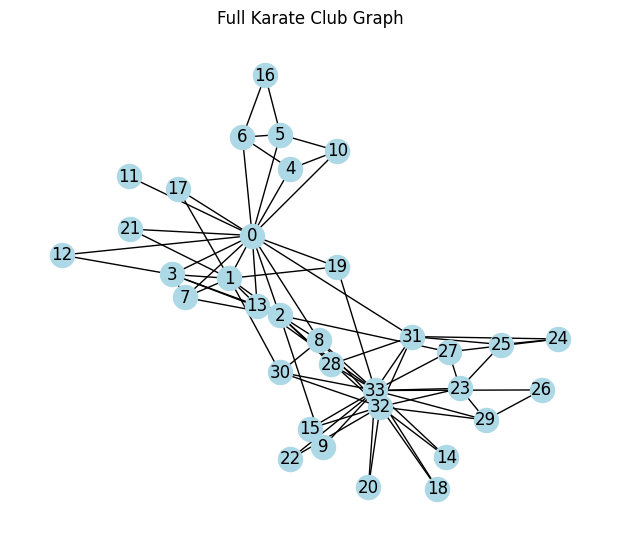

### ITERATION 0: full partition

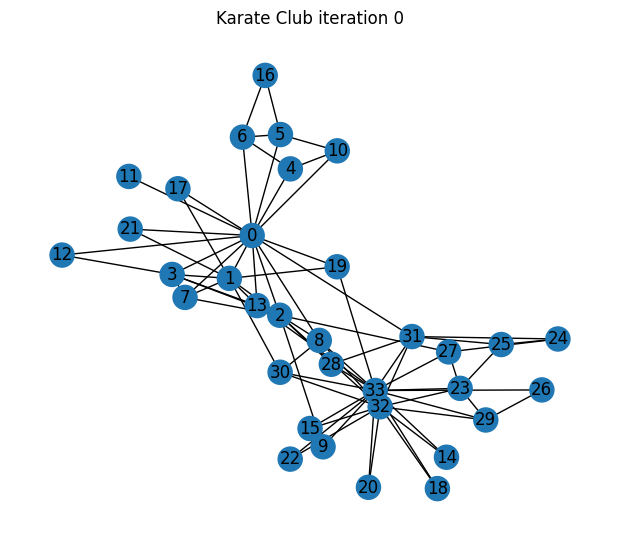

**Considering community of size 34**


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


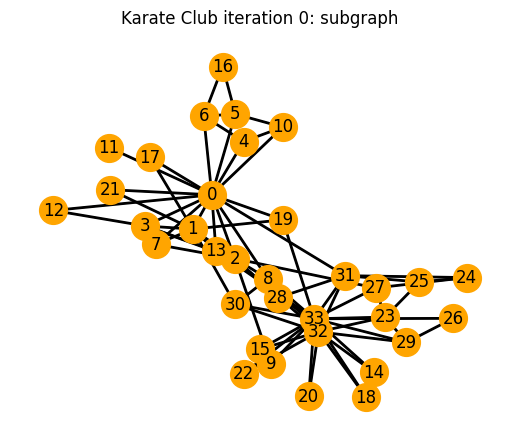


Action: spectral bisection on 34 nodes

Action: computing modularity matrix for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

A_sub:
[[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

B_sub:
[[-1.641026  3.076923  3.974359 ...  1.384615 -1.230769 -1.74359 ]
 [ 3.076923 -0.519231  5.423077 ... -0.346154 -0.692308 -0.980769]
 [ 3.974359  5.423077 -0.641026 ... -0.384615  1.230769 -1.089744]
 ...
 [ 1.384615 -0.346154 -0.384615 ... -0.230769  3.538462  3.346154]
 [-1.230769 -0.692308  1.230769 ...  3.538462 -0.923077  3.692308]
 [-1.74359  -0.980769 -1.089744 ...  3.346154  3.692308 -1.852564]]

Action: eigen-decomposition of B_sub

Eigenvalues (descending):
[17.107387 15.051246  9.278077  7.787504  4.637811  3.667466]

Leading eigenvector:
[-0.323652 -0.325258 -0.26399  -0.242372 -0.08232  -0.10

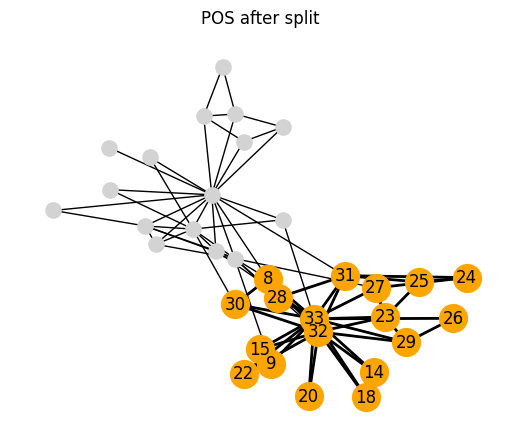


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


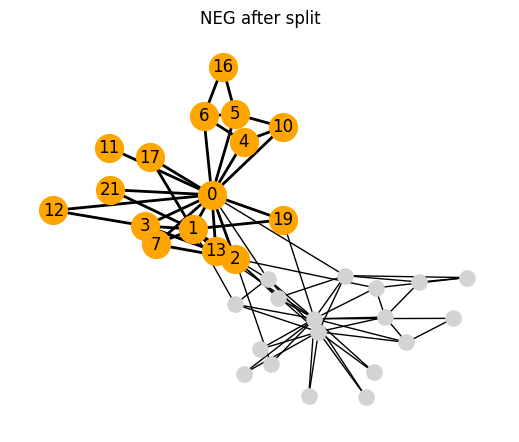

### ITERATION 1: full partition

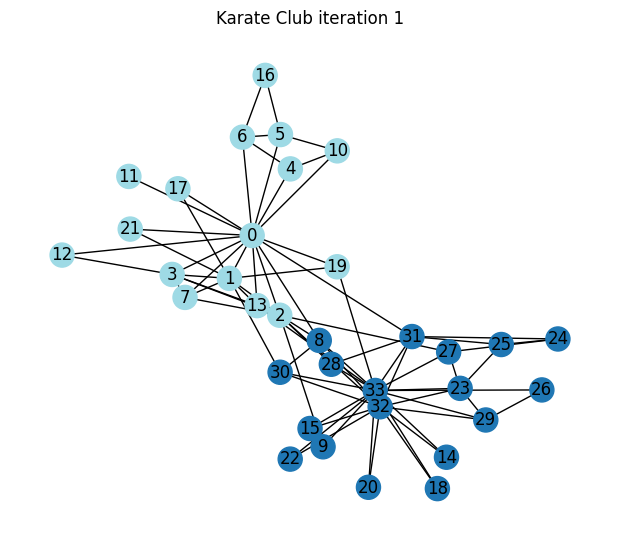

**Considering community of size 18**


Action: showing induced subgraph for nodes:
[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


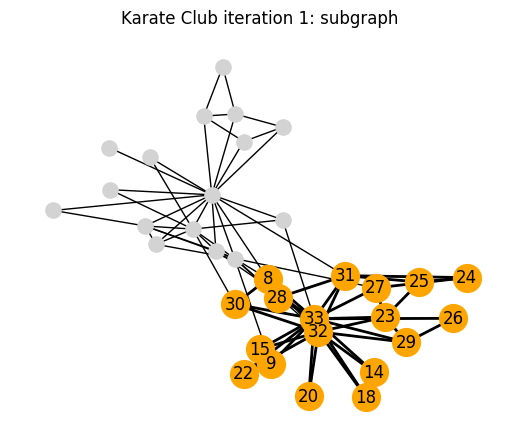


Action: spectral bisection on 18 nodes

Action: computing modularity matrix for nodes: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

A_sub:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 3. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 4. 0. 3. 0. 0. 5. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 3. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 5. 2. 0. 0. 0. 0. 0. 0. 7. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 4. 0. 0. 0. 0. 0. 4. 2.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

**Considering community of size 16**


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


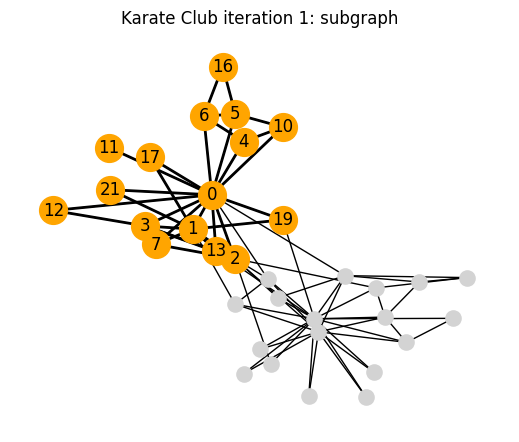


Action: spectral bisection on 16 nodes

Action: computing modularity matrix for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]

A_sub:
[[0. 4. 5. 3. 3. 3. 3. 2. 2. 3. 1. 3. 0. 2. 2. 2.]
 [4. 0. 6. 3. 0. 0. 0. 4. 0. 0. 0. 5. 0. 1. 2. 2.]
 [5. 6. 0. 3. 0. 0. 0. 4. 0. 0. 0. 3. 0. 0. 0. 0.]
 [3. 3. 3. 0. 0. 0. 0. 3. 0. 0. 3. 3. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0. 2. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0. 5. 0. 3. 0. 0. 0. 3. 0. 0. 0.]
 [3. 0. 0. 0. 2. 5. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [2. 4. 4. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 5. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

B_sub:
[[-1.641026  3.076923 

**No further splits — stopping.**

## Running recursive spectral split on: **Connected Caveman Graph**

Loaded Connected Caveman Graph: n=40, m=180

Adjacency matrix A:
[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 1. 0.]]


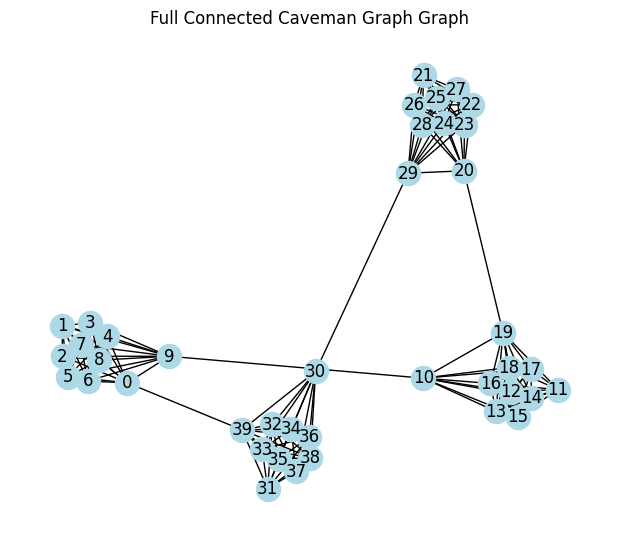

### ITERATION 0: full partition

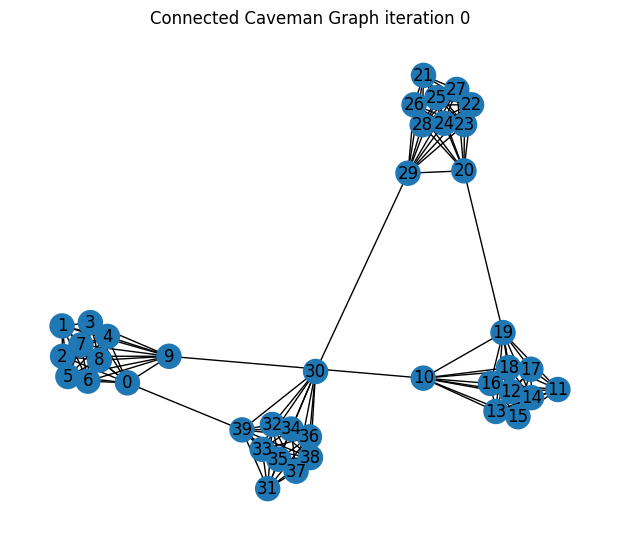

**Considering community of size 40**


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


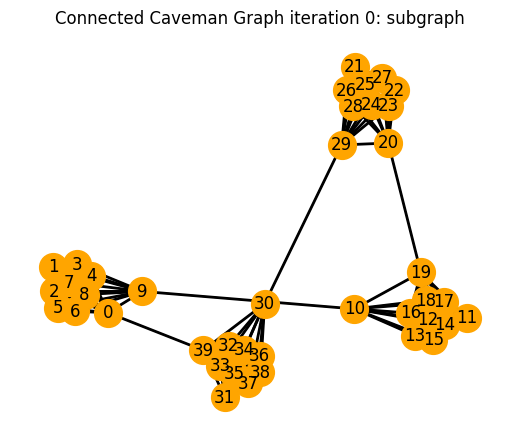


Action: spectral bisection on 40 nodes

Action: computing modularity matrix for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

A_sub:
[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 1. 0.]]

B_sub:
[[-0.225    -0.2       0.775    ... -0.225    -0.225     0.75    ]
 [-0.2      -0.177778  0.8      ... -0.2      -0.2      -0.222222]
 [ 0.775     0.8      -0.225    ... -0.225    -0.225    -0.25    ]
 ...
 [-0.225    -0.2      -0.225    ... -0.225     0.775     0.75    ]
 [-0.225    -0.2      -0.225    ...  0.775    -0.225     0.75    ]
 [ 0.75     -0.222222 -0.25     ...  0.75      0.75     -0.277778]]

Action: eigen-decomposition of B_sub

Eigenvalues (descending):
[8.834572 8.834572 8.641984 0.397214 0.360898 0.360898]

Leading eigenvector:
[-0.004293 -0.029709 -0.030145 -0.0301

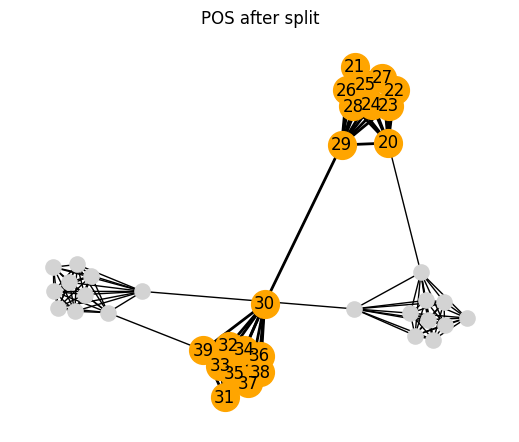


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


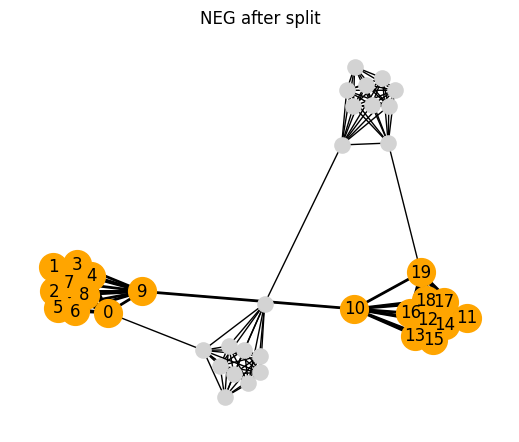

### ITERATION 1: full partition

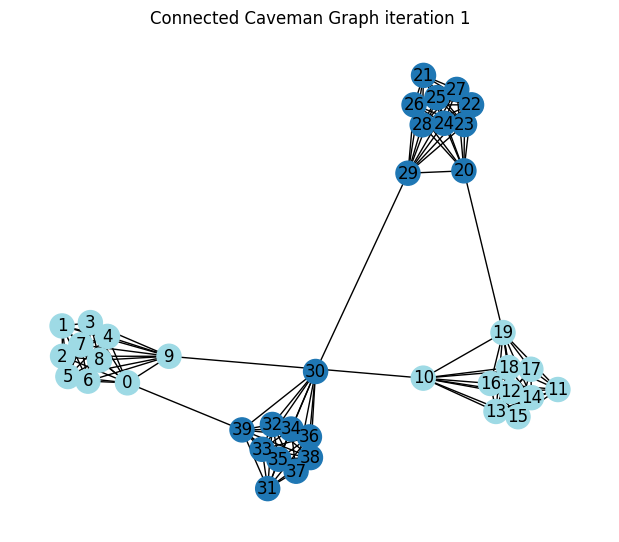

**Considering community of size 20**


Action: showing induced subgraph for nodes:
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


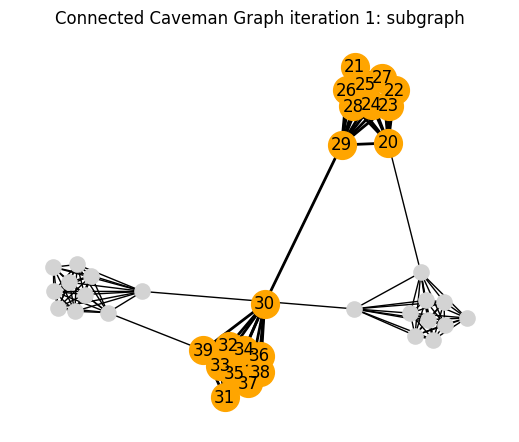


Action: spectral bisection on 20 nodes

Action: computing modularity matrix for nodes: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0.

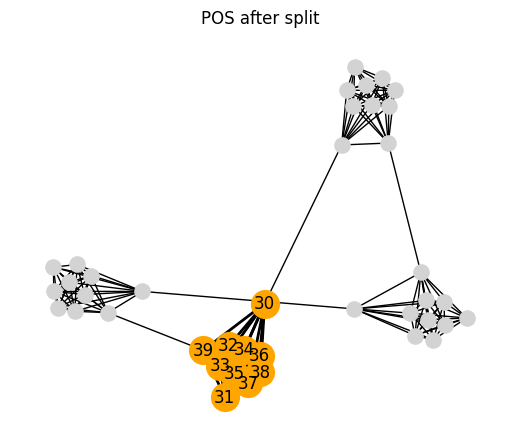


Action: showing induced subgraph for nodes:
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


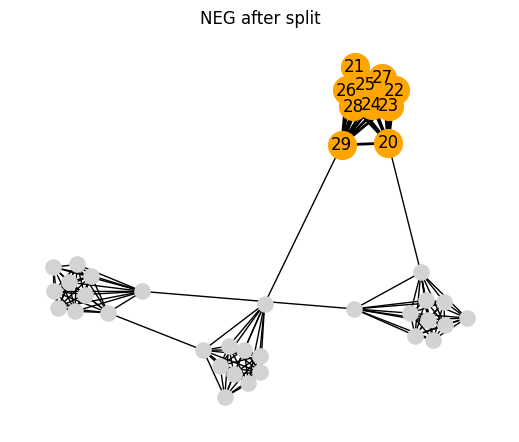

**Considering community of size 20**


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


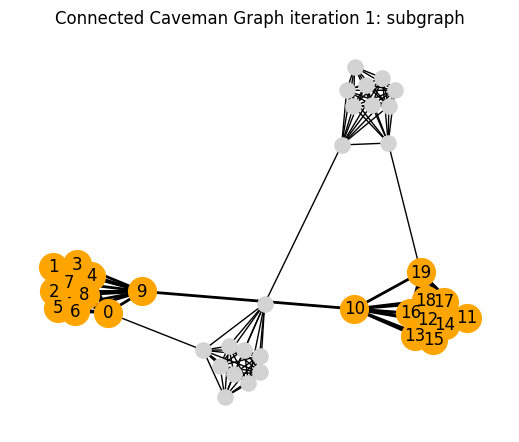


Action: spectral bisection on 20 nodes

Action: computing modularity matrix for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 

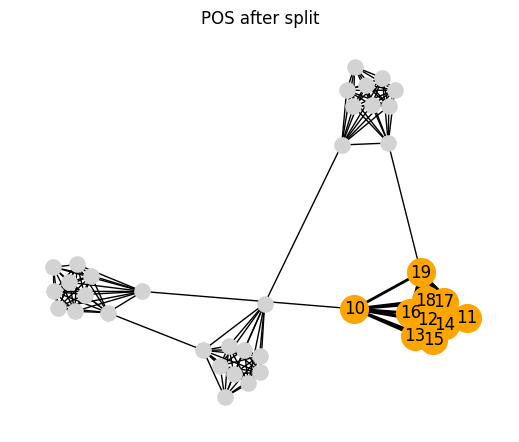


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


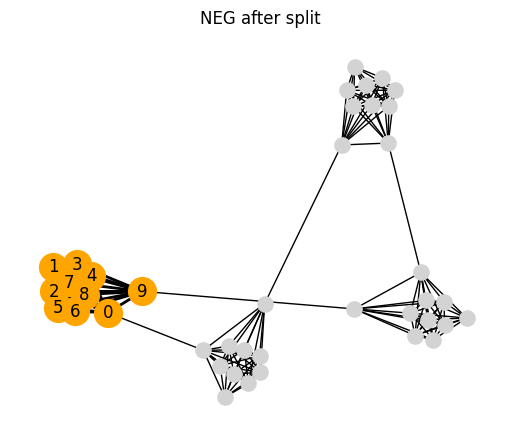

### ITERATION 2: full partition

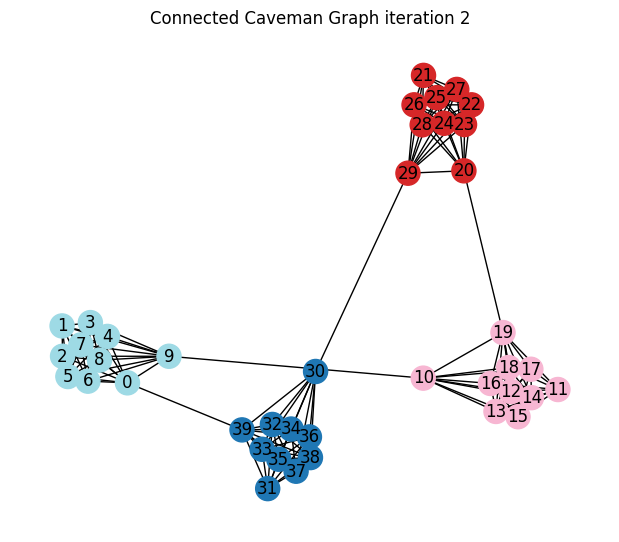

**Considering community of size 10**


Action: showing induced subgraph for nodes:
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


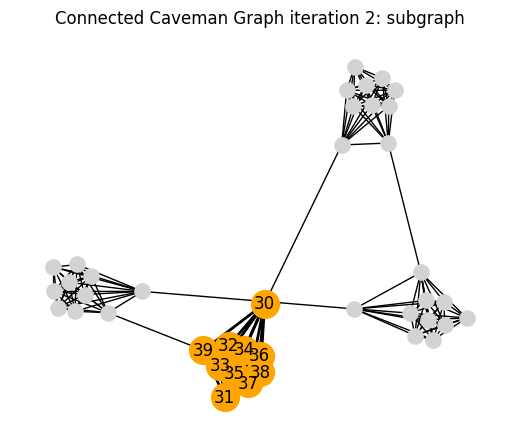


Action: spectral bisection on 10 nodes

Action: computing modularity matrix for nodes: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

B_sub:
[[-0.225    -0.2       0.775     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [-0.2      -0.177778  0.8       0.8       0.8       0.8       0.8
   0.8       0.8       0.777778]
 [ 0.775     0.8      -0.225     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775    -0.225     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775     0.775    -0.225     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8

**Considering community of size 10**


Action: showing induced subgraph for nodes:
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


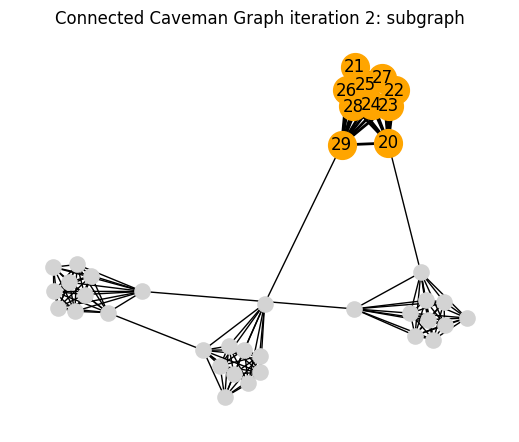


Action: spectral bisection on 10 nodes

Action: computing modularity matrix for nodes: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

B_sub:
[[-0.225    -0.2       0.775     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [-0.2      -0.177778  0.8       0.8       0.8       0.8       0.8
   0.8       0.8       0.777778]
 [ 0.775     0.8      -0.225     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775    -0.225     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775     0.775    -0.225     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8

**Considering community of size 10**


Action: showing induced subgraph for nodes:
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


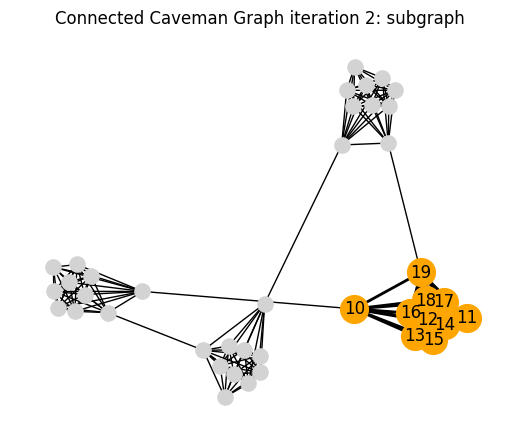


Action: spectral bisection on 10 nodes

Action: computing modularity matrix for nodes: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

B_sub:
[[-0.225    -0.2       0.775     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [-0.2      -0.177778  0.8       0.8       0.8       0.8       0.8
   0.8       0.8       0.777778]
 [ 0.775     0.8      -0.225     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775    -0.225     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775     0.775    -0.225     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8

**Considering community of size 10**


Action: showing induced subgraph for nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


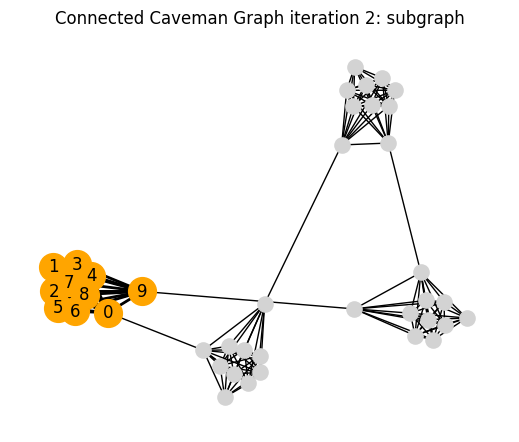


Action: spectral bisection on 10 nodes

Action: computing modularity matrix for nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

A_sub:
[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

B_sub:
[[-0.225    -0.2       0.775     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [-0.2      -0.177778  0.8       0.8       0.8       0.8       0.8
   0.8       0.8       0.777778]
 [ 0.775     0.8      -0.225     0.775     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775    -0.225     0.775     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.775     0.775    -0.225     0.775     0.775
   0.775     0.775     0.75    ]
 [ 0.775     0.8       0.7

**No further splits — stopping.**

In [23]:
# Cell 7: Recursive spectral community splitting on Karate + Connected Caveman Graph
from IPython.display import display, Markdown

def run_recursive_split(G_input, graph_name="graph"):
    """
    Runs recursive spectral modularity bisection on G_input.
    Prints short messages, matrices, eigenvalues, and shows all relevant graphs.
    """
    display(Markdown(f"## Running recursive spectral split on: **{graph_name}**"))
    
    # Local copies (avoid global variable collisions)
    G_local = G_input.copy()
    nodes_local = list(G_local.nodes())
    n_local = G_local.number_of_nodes()
    m_local = G_local.number_of_edges()
    A_local = nx.to_numpy_array(G_local, nodelist=nodes_local)
    deg_local = np.array([G_local.degree(u) for u in nodes_local], dtype=float)
    two_m_local = 2 * m_local
    pos_layout_local = nx.spring_layout(G_local, seed=42)
    
    print(f"Loaded {graph_name}: n={n_local}, m={m_local}")
    print("\nAdjacency matrix A:")
    print(np.round(A_local, 4))
    
    plt.figure(figsize=(6,5))
    nx.draw(G_local, pos_layout_local, with_labels=True, node_size=300, node_color='lightblue')
    plt.title(f"Full {graph_name} Graph")
    plt.show()

    # ----- Local helper functions -----

    def modularity_matrix_restricted_local(node_list):
        print(f"\nAction: computing modularity matrix for nodes: {node_list}")
        idx_local = [nodes_local.index(u) for u in node_list]
        A_sub_local = A_local[np.ix_(idx_local, idx_local)]
        k_sub_local = deg_local[idx_local]
        B_sub_local = A_sub_local - np.outer(k_sub_local, k_sub_local) / two_m_local
        
        print("\nA_sub:")
        print(np.round(A_sub_local, 6))
        print("\nB_sub:")
        print(np.round(B_sub_local, 6))
        
        return B_sub_local, idx_local

    def leading_eigenpair_local(B_local):
        print("\nAction: eigen-decomposition of B_sub")
        w_local, v_local = np.linalg.eigh(B_local)
        idx_sorted = np.argsort(w_local)[::-1]
        w_local = w_local[idx_sorted]
        v_local = v_local[:, idx_sorted]

        print("\nEigenvalues (descending):")
        print(np.round(w_local[:6], 6))
        print("\nLeading eigenvector:")
        print(np.round(v_local[:, 0], 6))

        return w_local[0], v_local[:, 0]

    def draw_full_partition_local(partition_local, title=None):
        assign_local = {}
        for cid, comp in enumerate(partition_local):
            for v in comp:
                assign_local[v] = cid
        
        colors_local = [assign_local[v] for v in nodes_local]
        plt.figure(figsize=(6,5))
        nx.draw(G_local, pos_layout_local, node_color=colors_local, cmap='tab20', with_labels=True)
        if title:
            plt.title(title)
        plt.show()

    def draw_induced_subgraph_local(node_list_local, title=None):
        print(f"\nAction: showing induced subgraph for nodes:")
        print(node_list_local)
        
        subG_local = G_local.subgraph(node_list_local)
        plt.figure(figsize=(5,4))
        
        # background faded
        nx.draw(G_local, pos_layout_local, node_color='lightgray', node_size=120, with_labels=False)
        
        # highlight subgraph
        nx.draw_networkx_nodes(subG_local, pos_layout_local, node_size=400, node_color='orange')
        nx.draw_networkx_labels(subG_local, pos_layout_local)
        nx.draw_networkx_edges(subG_local, pos_layout_local, width=2.0)
        
        if title:
            plt.title(title)
        plt.show()

    def spectral_bisect_local(node_list_local, threshold=1e-10):
        print(f"\nAction: spectral bisection on {len(node_list_local)} nodes")
        
        B_sub_local, _ = modularity_matrix_restricted_local(node_list_local)
        lam_local, u_local = leading_eigenpair_local(B_sub_local)
        
        if lam_local <= threshold:
            print("No split (eigenvalue too small).")
            return None, lam_local, u_local
        
        pos_nodes_local = [node_list_local[i] for i in range(len(node_list_local)) if u_local[i] > 0]
        neg_nodes_local = [node_list_local[i] for i in range(len(node_list_local)) if u_local[i] <= 0]
        
        print(f"Split sizes -> POS: {len(pos_nodes_local)}, NEG: {len(neg_nodes_local)}")
        return (pos_nodes_local, neg_nodes_local), lam_local, u_local

    # ----- Recursive splitting -----

    communities_local = [nodes_local.copy()]
    split_info_local = []
    iteration_local = 0
    
    while True:
        did_split = False
        new_communities_local = []

        display(Markdown(f"### ITERATION {iteration_local}: full partition"))
        draw_full_partition_local(communities_local, title=f"{graph_name} iteration {iteration_local}")

        for C_local in communities_local:
            display(Markdown(f"**Considering community of size {len(C_local)}**"))
            draw_induced_subgraph_local(C_local, title=f"{graph_name} iteration {iteration_local}: subgraph")
            
            result_local, lam_local, u_local = spectral_bisect_local(C_local)
            
            if result_local is None:
                new_communities_local.append(C_local)
            else:
                pos_group_local, neg_group_local = result_local
                
                if len(pos_group_local)==0 or len(neg_group_local)==0:
                    new_communities_local.append(C_local)
                else:
                    new_communities_local += [pos_group_local, neg_group_local]
                    split_info_local.append({
                        'iteration': iteration_local,
                        'parent_size': len(C_local),
                        'lam': float(lam_local),
                        'pos_size': len(pos_group_local),
                        'neg_size': len(neg_group_local)
                    })
                    draw_induced_subgraph_local(pos_group_local, title="POS after split")
                    draw_induced_subgraph_local(neg_group_local, title="NEG after split")
                    did_split = True

        communities_local = new_communities_local
        iteration_local += 1

        if not did_split:
            display(Markdown("**No further splits — stopping.**"))
            break

    return split_info_local, communities_local


# ----- RUN ON KARATE CLUB -----
G_karate = nx.karate_club_graph()
split_info_karate, communities_karate = run_recursive_split(G_karate, "Karate Club")


# ----- RUN ON CONNECTED CAVEMAN GRAPH -----
G_caveman = nx.connected_caveman_graph(4, 10)   # 4 communities of size 10
split_info_caveman, communities_caveman = run_recursive_split(G_caveman, "Connected Caveman Graph")


In [24]:
# Cell 8: Summaries for Karate Club and Caveman Graph
from IPython.display import Markdown, display

display(Markdown("## SUMMARY OF RESULTS"))

print("---- Karate Club Splits ----")
for s in split_info_karate:
    print(s)

print("\nFinal Karate Club communities:")
for i, c in enumerate(communities_karate):
    print(f"Community {i}: size={len(c)} nodes={sorted(c)}")

print("\n---- Connected Caveman Splits ----")
for s in split_info_caveman:
    print(s)

print("\nFinal Caveman communities:")
for i, c in enumerate(communities_caveman):
    print(f"Community {i}: size={len(c)} nodes={sorted(c)}")

display(Markdown("**Done — both graphs processed with full stepwise visualizations.**"))


## SUMMARY OF RESULTS

---- Karate Club Splits ----
{'iteration': 0, 'parent_size': 34, 'lam': 17.107386763280694, 'pos_size': 18, 'neg_size': 16}

Final Karate Club communities:
Community 0: size=18 nodes=[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 1: size=16 nodes=[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]

---- Connected Caveman Splits ----
{'iteration': 0, 'parent_size': 40, 'lam': 8.83457198618707, 'pos_size': 20, 'neg_size': 20}
{'iteration': 1, 'parent_size': 20, 'lam': 8.729170182373718, 'pos_size': 10, 'neg_size': 10}
{'iteration': 1, 'parent_size': 20, 'lam': 8.729170182373718, 'pos_size': 10, 'neg_size': 10}

Final Caveman communities:
Community 0: size=10 nodes=[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Community 1: size=10 nodes=[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Community 2: size=10 nodes=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Community 3: size=10 nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


**Done — both graphs processed with full stepwise visualizations.**

## STEP 9 — Metric evolution across iterations (per node, per iteration)

### Running split with history on: **Karate Club**

### Running split with history on: **Connected Caveman Graph**

### Karate Club — metric evolution

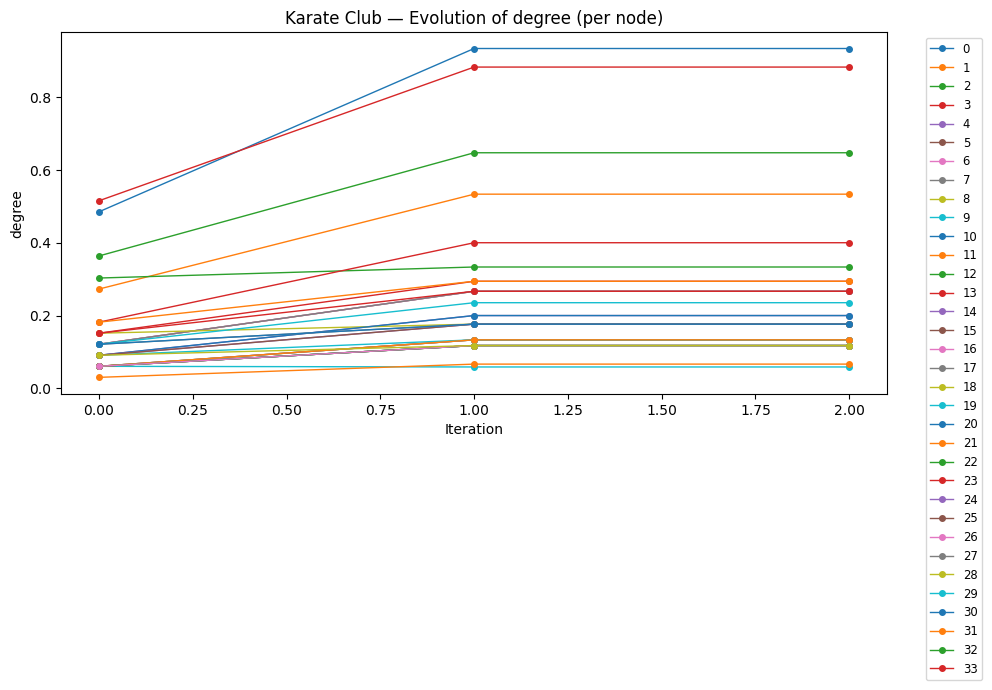

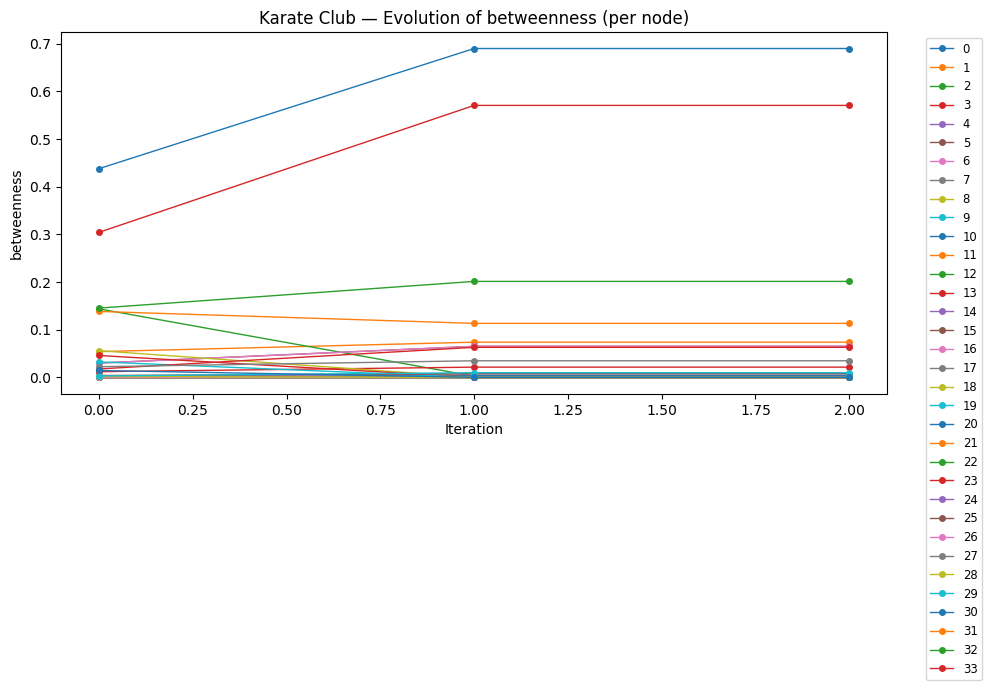

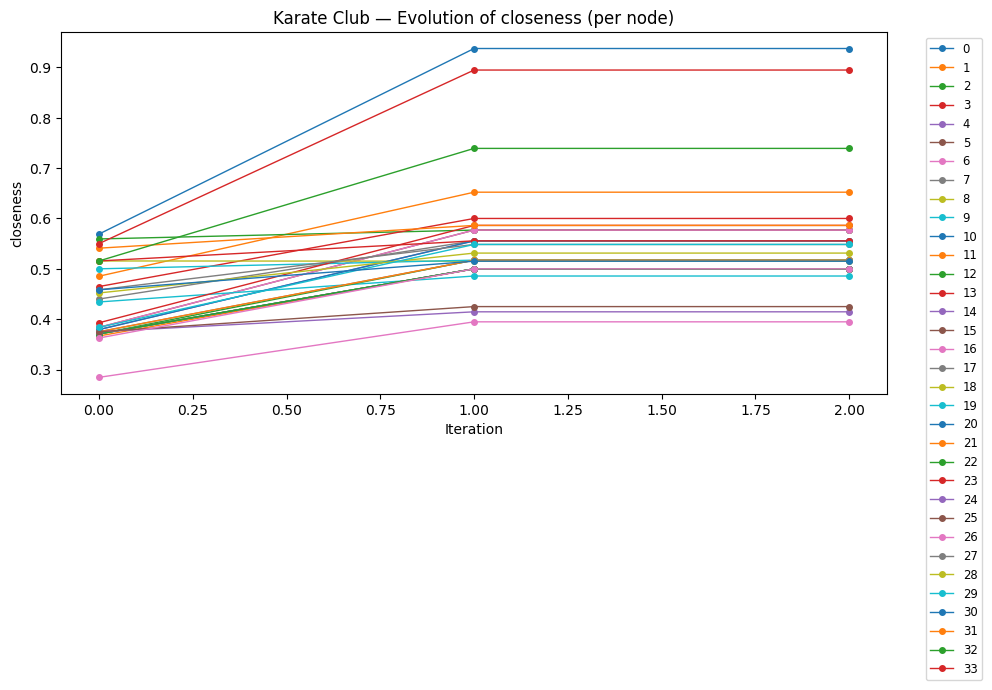

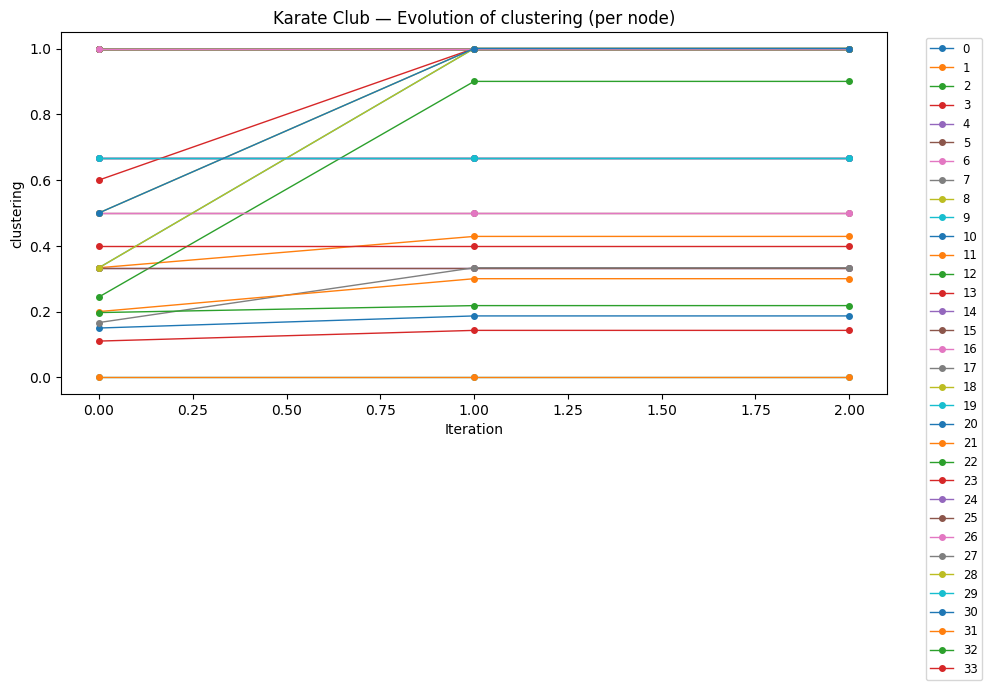

### Connected Caveman Graph — metric evolution

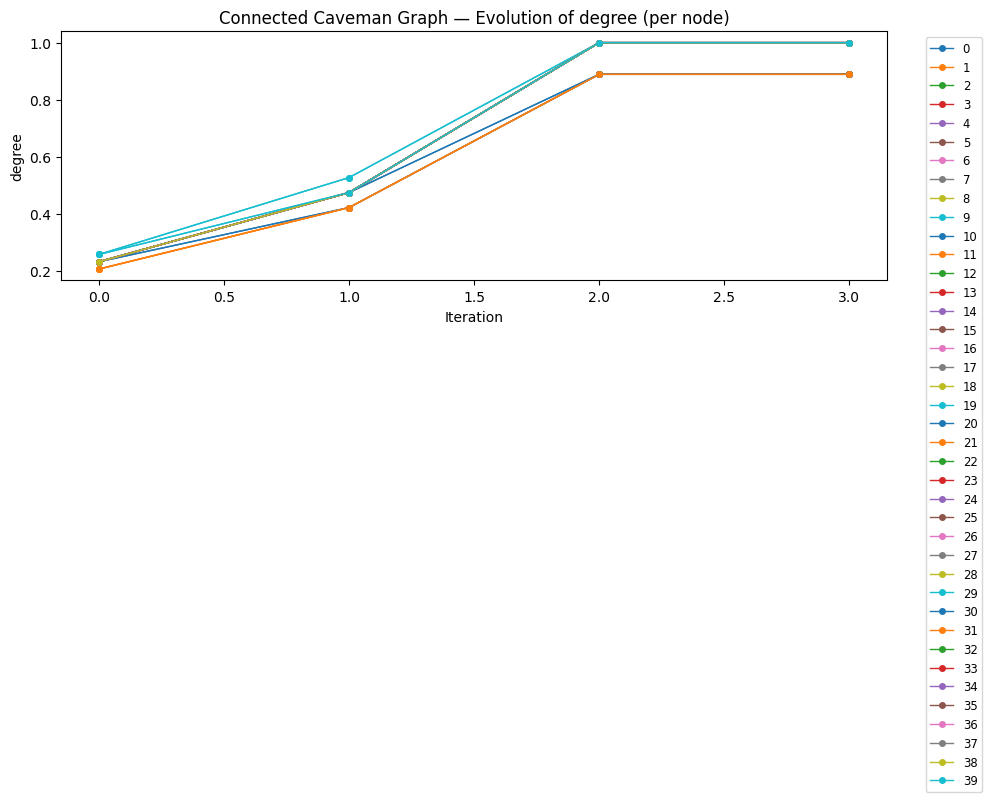

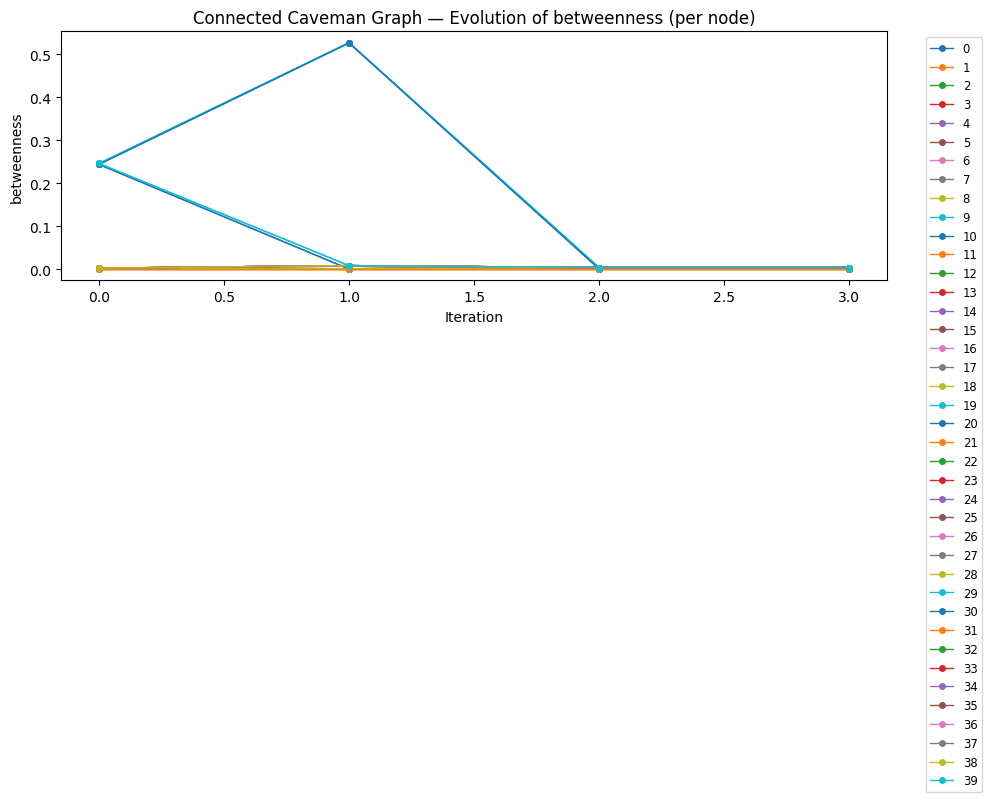

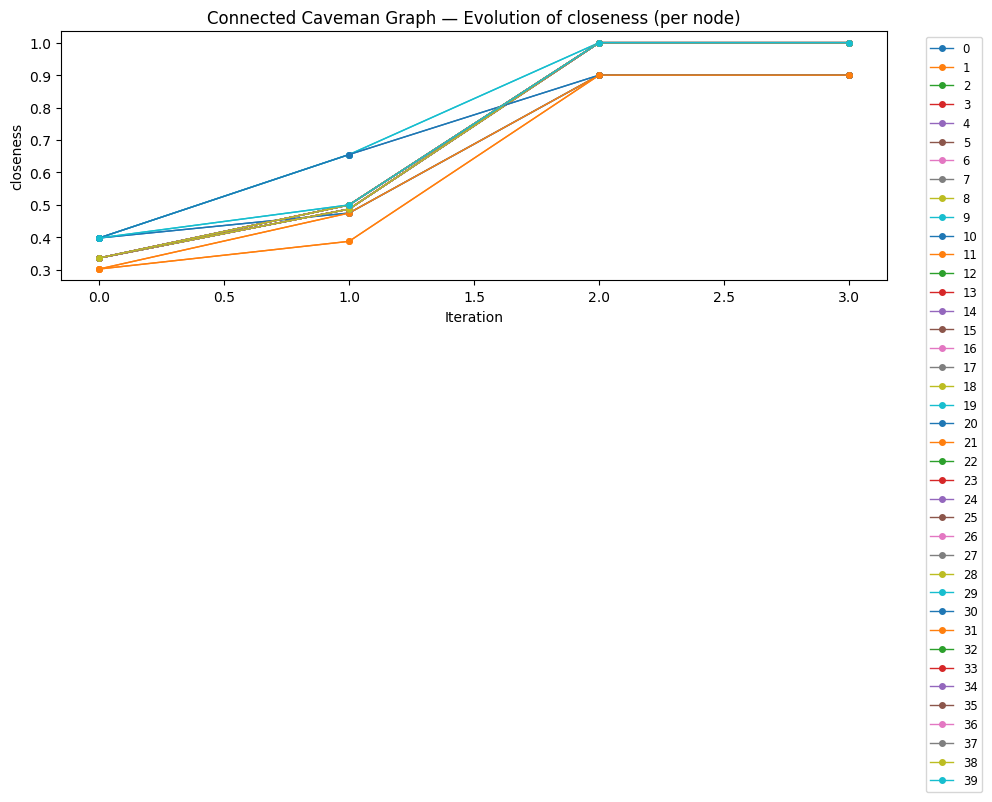

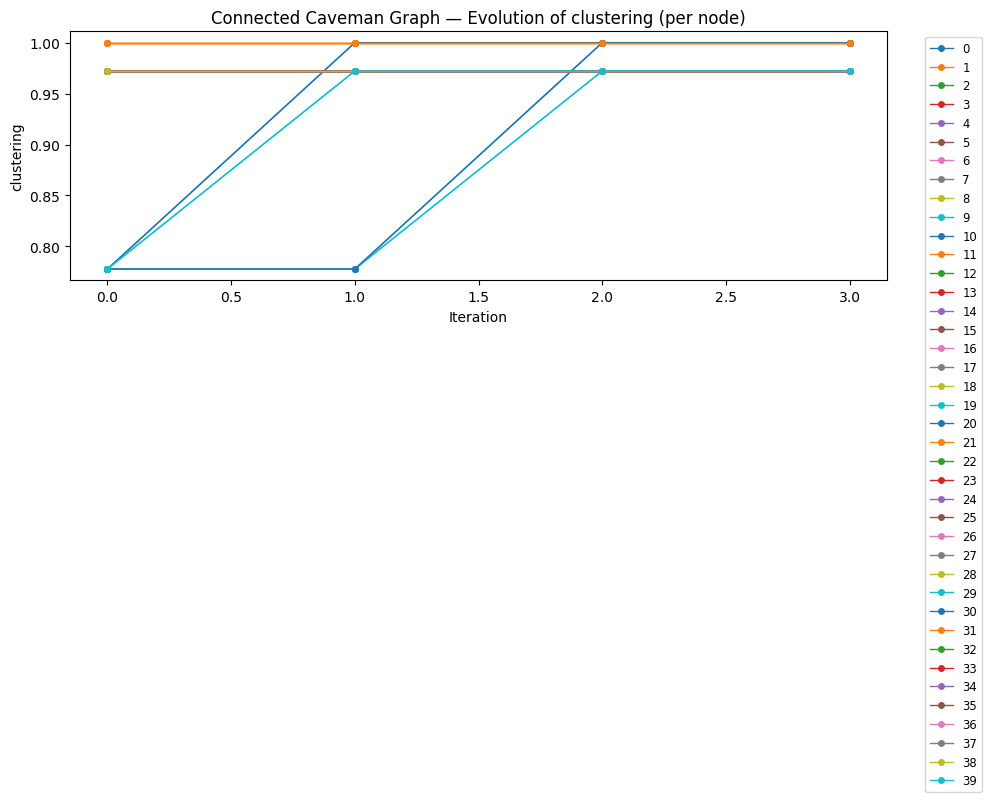

Step 9 complete — metric evolution plots shown for every node across iterations.

In [25]:
# Cell 9: Re-run splitting while recording history, compute per-node metric history (within induced subgraphs),
# and plot evolution of metrics for every node across iterations.
from IPython.display import display, Markdown

display(Markdown("## STEP 9 — Metric evolution across iterations (per node, per iteration)"))

def run_recursive_split_with_history(G_input, graph_name="graph"):
    """
    Same as run_recursive_split but returns history_partitions: list of partitions after each iteration.
    Each partition is a list of communities (lists of node ids).
    """
    display(Markdown(f"### Running split with history on: **{graph_name}**"))
    G_local = G_input.copy()
    nodes_local = list(G_local.nodes())
    A_local = nx.to_numpy_array(G_local, nodelist=nodes_local)
    deg_local = np.array([G_local.degree(u) for u in nodes_local], dtype=float)
    two_m_local = 2 * G_local.number_of_edges()
    pos_layout_local = nx.spring_layout(G_local, seed=42)

    # local helper functions (slightly simplified, print key actions)
    def modularity_matrix_restricted_local(node_list):
        idx_local = [nodes_local.index(u) for u in node_list]
        A_sub_local = A_local[np.ix_(idx_local, idx_local)]
        k_sub_local = deg_local[idx_local]
        B_sub_local = A_sub_local - np.outer(k_sub_local, k_sub_local) / two_m_local
        return B_sub_local, idx_local

    def leading_eigenpair_local(B_local):
        w_local, v_local = np.linalg.eigh(B_local)
        idxs = np.argsort(w_local)[::-1]
        w_local = w_local[idxs]
        v_local = v_local[:, idxs]
        return w_local[0], v_local[:, 0]

    def spectral_bisect_local(node_list_local, threshold=1e-10):
        B_sub_local, _ = modularity_matrix_restricted_local(node_list_local)
        lam_local, u_local = leading_eigenpair_local(B_sub_local)
        if lam_local <= threshold:
            return None, lam_local, u_local
        pos_nodes_local = [node_list_local[i] for i in range(len(node_list_local)) if u_local[i] > 0]
        neg_nodes_local = [node_list_local[i] for i in range(len(node_list_local)) if u_local[i] <= 0]
        return (pos_nodes_local, neg_nodes_local), lam_local, u_local

    # run recursion and record history_partitions
    communities_local = [nodes_local.copy()]
    history_partitions = [ [c.copy() for c in communities_local] ]  # include initial partition
    iteration_local = 0

    while True:
        did_split_local = False
        new_communities_local = []

        # For reproducibility we do not print every internal matrix here (we already had earlier cells),
        # but we still display the partition/induced subgraphs in earlier cells if desired.
        for C_local in communities_local:
            result_local, lam_local, u_local = spectral_bisect_local(C_local)
            if result_local is None:
                new_communities_local.append(C_local)
            else:
                pos_group_local, neg_group_local = result_local
                if len(pos_group_local)==0 or len(neg_group_local)==0:
                    new_communities_local.append(C_local)
                else:
                    new_communities_local += [pos_group_local, neg_group_local]
                    did_split_local = True

        communities_local = new_communities_local
        history_partitions.append([c.copy() for c in communities_local])
        iteration_local += 1

        if not did_split_local:
            break

    # return history of partitions and final communities
    return history_partitions, communities_local

# Run for Karate and Caveman — this will give us history_partitions each
history_karate, final_karate = run_recursive_split_with_history(nx.karate_club_graph(), "Karate Club")
history_caveman, final_caveman = run_recursive_split_with_history(nx.connected_caveman_graph(4, 10), "Connected Caveman Graph")

# Function to compute per-node metrics for each partition in a history
def compute_metric_history(G, history_partitions):
    """
    For each iteration (partition) and each node:
      - compute metrics on the induced subgraph containing that node
      - metrics: degree_centrality, betweenness_centrality, closeness_centrality, clustering
    Returns:
      - metrics_history: dict mapping metric_name -> dict(node -> list of values across iterations)
      - iterations: number of iterations (len(history_partitions))
    """
    metrics = ['degree', 'betweenness', 'closeness', 'clustering']
    nodes_list = list(G.nodes())
    metrics_history = {m: {v: [] for v in nodes_list} for m in metrics}

    for part_idx, partition in enumerate(history_partitions):
        # for each community in partition, compute centralities on the induced subgraph
        # then assign those values to nodes belonging to that community
        # note: every node belongs to exactly one community in partition
        for community in partition:
            subG = G.subgraph(community)
            # compute centralities on the subgraph
            # if subG has 1 node, networkx centralities return 0 for betweenness/closeness/clustering
            degc = nx.degree_centrality(subG)   # normalized by (n_sub-1)
            btw = nx.betweenness_centrality(subG, normalized=True)  # for small subgraphs may be zeros
            clo = nx.closeness_centrality(subG)  # if isolated node, closeness may be 0
            clust = nx.clustering(subG)          # clustering coefficient in subgraph

            for node in community:
                metrics_history['degree'][node].append(degc.get(node, 0.0))
                metrics_history['betweenness'][node].append(btw.get(node, 0.0))
                metrics_history['closeness'][node].append(clo.get(node, 0.0))
                metrics_history['clustering'][node].append(clust.get(node, 0.0))

    return metrics_history, len(history_partitions)

# Compute metric histories
metrics_hist_karate, iters_karate = compute_metric_history(nx.karate_club_graph(), history_karate)
metrics_hist_caveman, iters_caveman = compute_metric_history(nx.connected_caveman_graph(4, 10), history_caveman)

# Plotting function: one figure per metric, with one line per node
def plot_metric_evolution(metrics_history, num_iters, graph_name):
    iterations = list(range(num_iters))
    for metric_name, node_dict in metrics_history.items():
        plt.figure(figsize=(10,6))
        for node, vals in node_dict.items():
            # ensure length equals num_iters
            if len(vals) < num_iters:
                # if a node somehow missing values (shouldn't happen), pad with last
                vals = vals + [vals[-1]]*(num_iters - len(vals))
            plt.plot(iterations, vals, marker='o', linewidth=1, markersize=4, label=str(node))
        plt.xlabel('Iteration')
        plt.ylabel(metric_name)
        plt.title(f'{graph_name} — Evolution of {metric_name} (per node)')
        # legend can be large; place it outside
        plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=1, fontsize='small')
        plt.tight_layout()
        plt.show()

# Plot for Karate
display(Markdown("### Karate Club — metric evolution"))
plot_metric_evolution(metrics_hist_karate, iters_karate, "Karate Club")

# Plot for Connected Caveman
display(Markdown("### Connected Caveman Graph — metric evolution"))
plot_metric_evolution(metrics_hist_caveman, iters_caveman, "Connected Caveman Graph")

display(Markdown("Step 9 complete — metric evolution plots shown for every node across iterations."))
